In [1]:
# import the transcriptome data
import os
import dandelion as ddl
import pandas as pd
import scanpy as sc
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 leidenalg==0.8.2


In [2]:
ddl.__version__

'0.0.26'

In [3]:
os.getcwd()

'/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/notebooks'

In [4]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid')

In [5]:
adata = sc.read_h5ad('cambridge/cambridge_Final.h5ad')
adata

AnnData object with n_obs × n_vars = 180842 × 33541
    obs: 'CellID', 'cell', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'UMAP1', 'UMAP2', 'Sample', 'PatientID', 'Day', 'Age', 'Sex', 'Classification', 'COVID_19_Status', 'O2_group', 'Group_Severity', 'labels', 'Group_Severity_2', 'Status', 'collection_location', 'days_from_sx_or_swab', 'swab_results', 'CellType.Sub', 'Sub.Cluster', 'CellType.Broad'
    var: 'ID', 'Symbol', 'Type'

In [6]:
len(list(set([a.split('_')[1] for a in list(set(adata.obs['donor_id']))])))

47

In [7]:
# For demultiplexing the BCR, i will first edit the BCR contigs to match the transcriptome barcodes, which basically looks like appending the sequencing lane ID to each of the barcodes.
# had to manually change the file names from filtered_contig_annotation.csv to filtered_contig_annotations.csv
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/cambridge/BCR')
folders = ['BGCV01_BCR', 'BGCV02_BCR', 'BGCV03_BCR', 'BGCV04_BCR', 'BGCV05_BCR', 'BGCV06_BCR', 'BGCV07_BCR', 'BGCV08_BCR','BGCV09_BCR', 'BGCV10_BCR', 'BGCV11_BCR', 'BGCV12_BCR', 'BGCV13_BCR', 'BGCV14_BCR', 'BGCV15_BCR']
prefixes = [sample.split('_BCR')[0] for sample in folders]
ddl.pp.format_fastas(folders, prefix = prefixes, remove_trailing_hyphen_number=False)

Formating fasta(s) : 100%|██████████| 15/15 [01:21<00:00,  5.42s/it]


In [8]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/cambridge/BCR')
folders = ['BGCV01_BCR', 'BGCV02_BCR', 'BGCV03_BCR', 'BGCV04_BCR', 'BGCV05_BCR', 'BGCV06_BCR', 'BGCV07_BCR', 'BGCV08_BCR','BGCV09_BCR', 'BGCV10_BCR', 'BGCV11_BCR', 'BGCV12_BCR', 'BGCV13_BCR', 'BGCV14_BCR', 'BGCV15_BCR']
prefixes = [sample.split('_BCR')[0] for sample in folders]

In [9]:
# repeat the BCR demultiplexing like what i did with Rik's data 
# currently there's 15 fasta files and contig annotations corresponding to the 60 patients, and the fasta headers and contig_annotations are now edited to match to the transcriptome barcodes, or CellID.
# so first, create a dictionary mapping the CellID to donor_id
barcode_dictionary = dict(zip(adata.obs['CellID'], adata.obs['donor_id']))
barcode_dictionary

{'BGCV01_AAACCTGAGACCGGAT-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGAGAGGTAGA-1': 'BGCV01_CV0025',
 'BGCV01_AAACCTGAGATGCGAC-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGAGCGCCTCA-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGAGCGTGAAC-1': 'BGCV01_CV0025',
 'BGCV01_AAACCTGAGCTTATCG-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGAGGAACTGC-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGAGGAGTCTG-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGAGGGATCTG-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGAGGGCATGT-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGAGTGAACAT-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCAACGCACC-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCACACGCTG-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCACGTGAGA-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCAGCTGCTG-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGCAGTCAGAG-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCAGTCGTGC-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCATAAAGGT-1': 'BGCV01_CV0904',
 'BGCV01_AAACCTGCATCCCACT-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCATTACGAC-1': 'BGCV01_CV0902',
 'BGCV01_AAACCTGCATTGAGCT-1': 'BGCV01_CV0904',
 'BGCV01_AAAC

In [10]:
# specify file paths
contig_files = [f +'/dandelion/data/filtered_contig_annotations.csv' for f in folders]
fasta_files = [f + '/dandelion/data/filtered_contig.fasta' for f in folders]

In [11]:
# append all the contig_annotation files into a single data frame
# skipping format_fastas because of how i need to do the manual editing
contig_annotations = pd.DataFrame()
for i in range(len(contig_files)):
    annot = pd.read_csv(contig_files[i])
    # add the patient_id here
    annot['patient_id'] = [barcode_dictionary[b].split('_')[1] if b in barcode_dictionary.keys() else None for b in annot['barcode']]
    contig_annotations = contig_annotations.append(annot)

In [12]:
# create a dictionary mapping contig_id to patient_id
contig_dict = dict(zip(contig_annotations['contig_id'], contig_annotations['patient_id']))

In [13]:
# what are the unique patient_ids?
sorted([l for l in list(set(contig_annotations['patient_id'])) if l is not None])

['CV0025',
 'CV0037',
 'CV0050',
 'CV0052',
 'CV0058',
 'CV0059',
 'CV0062',
 'CV0068',
 'CV0073',
 'CV0074',
 'CV0084',
 'CV0094',
 'CV0100',
 'CV0104',
 'CV0120',
 'CV0128',
 'CV0134',
 'CV0137',
 'CV0144',
 'CV0155',
 'CV0160',
 'CV0164',
 'CV0171',
 'CV0176',
 'CV0178',
 'CV0180',
 'CV0198',
 'CV0200',
 'CV0201',
 'CV0231',
 'CV0234',
 'CV0257',
 'CV0262',
 'CV0279',
 'CV0284',
 'CV0326',
 'CV0902',
 'CV0904',
 'CV0911',
 'CV0915',
 'CV0917',
 'CV0926',
 'CV0929',
 'CV0934',
 'CV0939',
 'CV0940',
 'CV0944']

In [14]:
patients = [l for l in list(set(contig_annotations['patient_id'])) if l is not None]

In [14]:
# read in the fasta files as a dictionary
from dandelion.utilities import fasta_iterator, Write_output
# create empty dictionaries to hold the fasta header and corresponding sequence. Doing this with defaultdict so I don't have to keep writing the code
from collections import defaultdict
dct = defaultdict(dict)
for i in range(len(fasta_files)):
    fh = open(fasta_files[i], 'r')
    for header, sequence in fasta_iterator(fh):
        for p in patients:
            if contig_dict[header] == p:
                dct[p][header] = sequence
    fh.close()    

In [15]:
# so the idea is to create a new folder holding the matched up contigs and annotations in a folder for each patient.
for k in dct.keys():
    # create out paths
    if not os.path.exists(k+'/dandelion/data'):
        os.makedirs(k+'/dandelion/data')
    # create name for out names
    out_fasta = k + '/dandelion/data/filtered_contig.fasta'
    out_annot = k + '/dandelion/data/filtered_contig_annotations.csv'
    fh1 = open(out_fasta, 'w')
    fh1.close()
    out = ''
    for l in dct[k]:
        out = '>'+l+'\n'+dct[k][l]+'\n'
        Write_output(out, out_fasta)
    data = contig_annotations[contig_annotations['patient_id'] == k]
    data.to_csv(out_annot, index = False)

In [16]:
# Now to start dandelion pre-processing proper
ddl.pp.reannotate_genes(patients)

Assigning genes : 100%|██████████| 47/47 [30:25<00:00, 38.84s/it]


In [15]:
# run reassign alleles
# create a dictionary to facilitate that. Using this dictionary means it should just return the results back into the original folder.
group_dict = dict(zip(patients, patients))

In [16]:
group_dict

{'CV0917': 'CV0917',
 'CV0915': 'CV0915',
 'CV0201': 'CV0201',
 'CV0911': 'CV0911',
 'CV0279': 'CV0279',
 'CV0940': 'CV0940',
 'CV0120': 'CV0120',
 'CV0074': 'CV0074',
 'CV0052': 'CV0052',
 'CV0058': 'CV0058',
 'CV0180': 'CV0180',
 'CV0160': 'CV0160',
 'CV0171': 'CV0171',
 'CV0944': 'CV0944',
 'CV0231': 'CV0231',
 'CV0059': 'CV0059',
 'CV0257': 'CV0257',
 'CV0200': 'CV0200',
 'CV0137': 'CV0137',
 'CV0134': 'CV0134',
 'CV0062': 'CV0062',
 'CV0144': 'CV0144',
 'CV0178': 'CV0178',
 'CV0084': 'CV0084',
 'CV0128': 'CV0128',
 'CV0902': 'CV0902',
 'CV0234': 'CV0234',
 'CV0904': 'CV0904',
 'CV0164': 'CV0164',
 'CV0050': 'CV0050',
 'CV0929': 'CV0929',
 'CV0939': 'CV0939',
 'CV0073': 'CV0073',
 'CV0037': 'CV0037',
 'CV0198': 'CV0198',
 'CV0100': 'CV0100',
 'CV0934': 'CV0934',
 'CV0104': 'CV0104',
 'CV0926': 'CV0926',
 'CV0262': 'CV0262',
 'CV0284': 'CV0284',
 'CV0025': 'CV0025',
 'CV0094': 'CV0094',
 'CV0068': 'CV0068',
 'CV0326': 'CV0326',
 'CV0155': 'CV0155',
 'CV0176': 'CV0176'}

Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


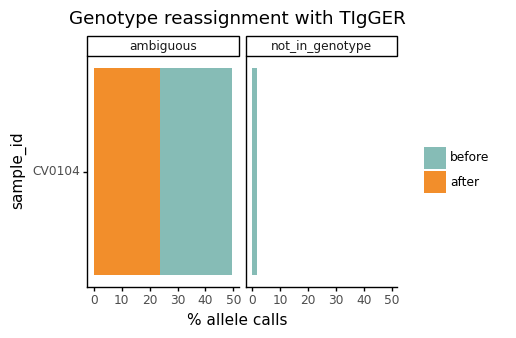

<ggplot: (1454188401945)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


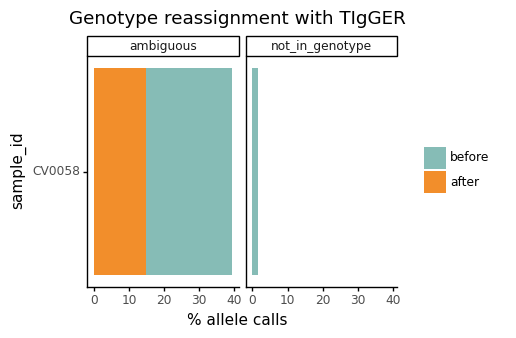

<ggplot: (1454187520193)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


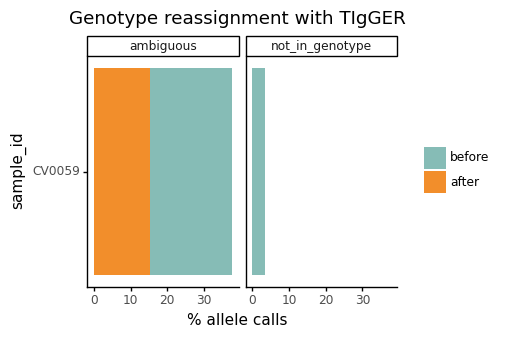

<ggplot: (1454187244885)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


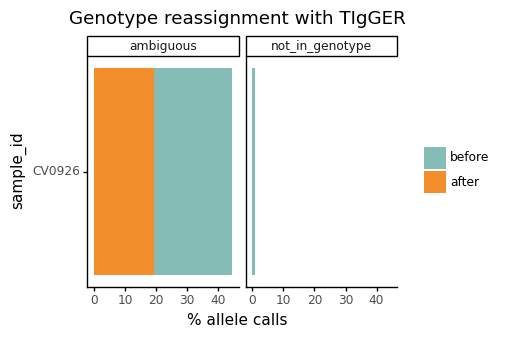

<ggplot: (1454187195889)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


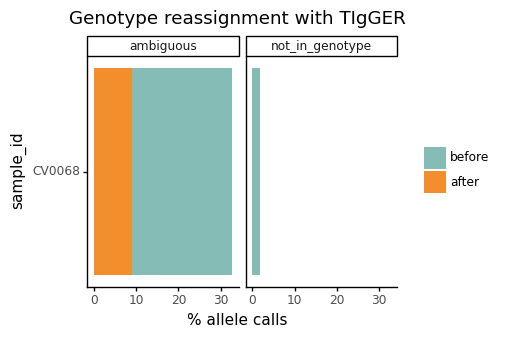

<ggplot: (1454186336813)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


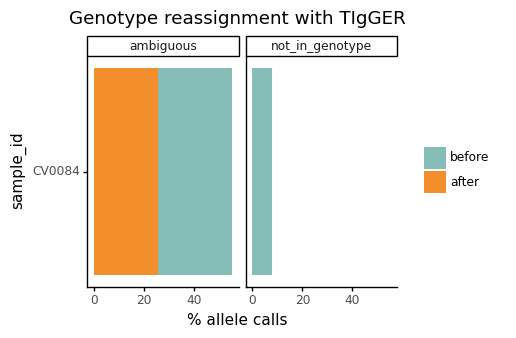

<ggplot: (1454186336569)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


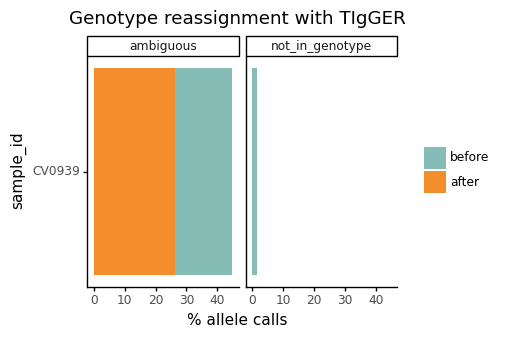

<ggplot: (1454181806305)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


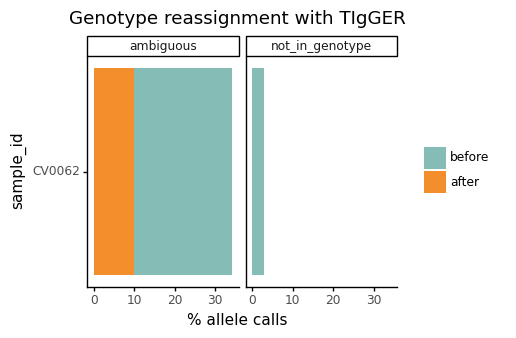

<ggplot: (1454181735785)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


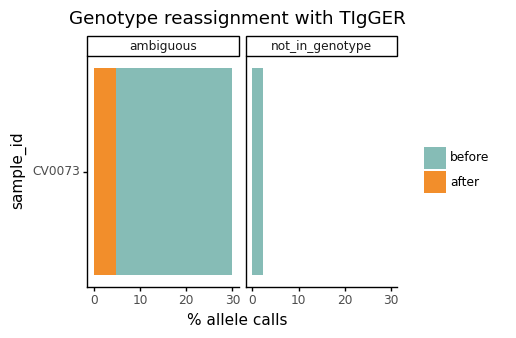

<ggplot: (1454181963201)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


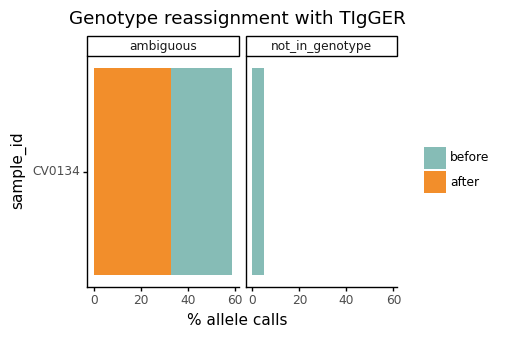

<ggplot: (1454180332985)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


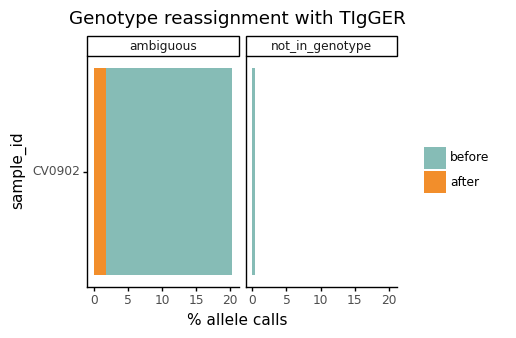

<ggplot: (1454187173677)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


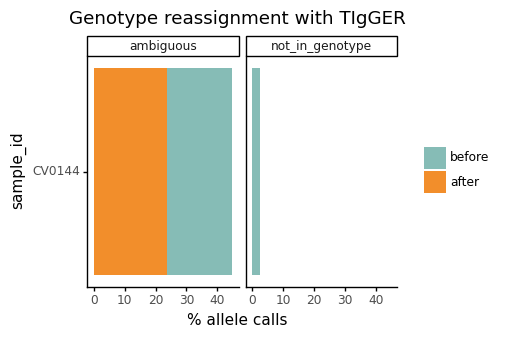

<ggplot: (1454188536145)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


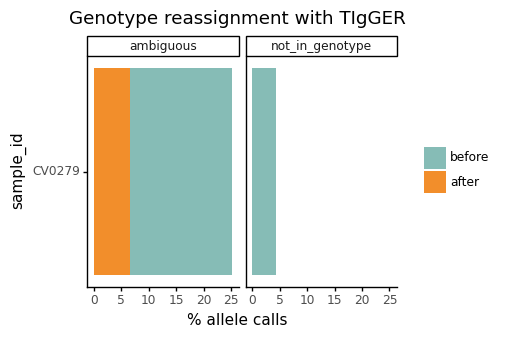

<ggplot: (1454188532689)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


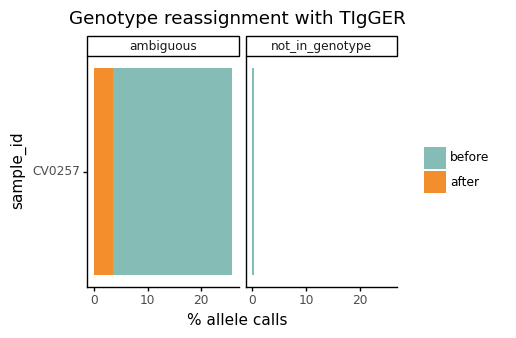

<ggplot: (1454186808885)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


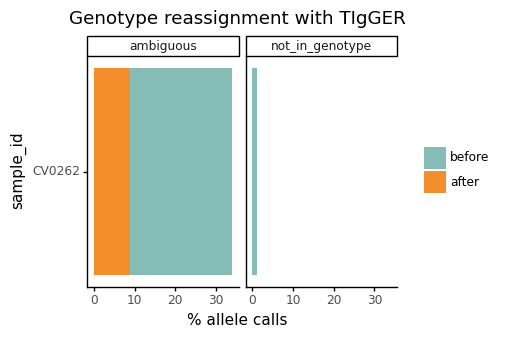

<ggplot: (1454186730017)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


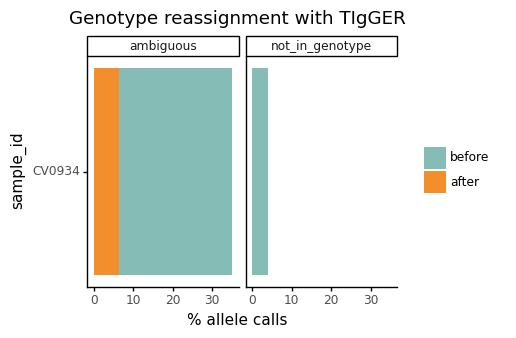

<ggplot: (1454181429753)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


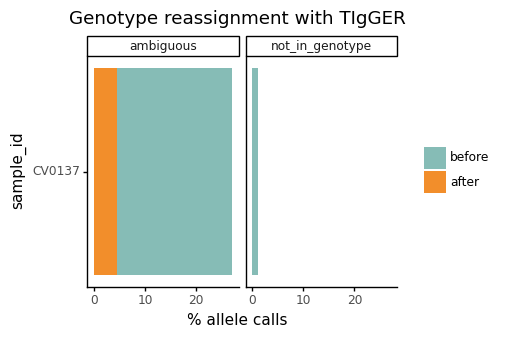

<ggplot: (1454180673245)>


Processing data file(s) : 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


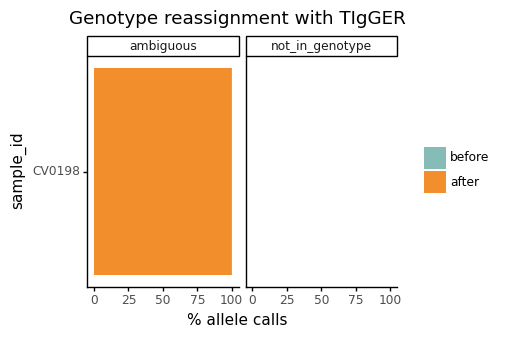

<ggplot: (1454179864701)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


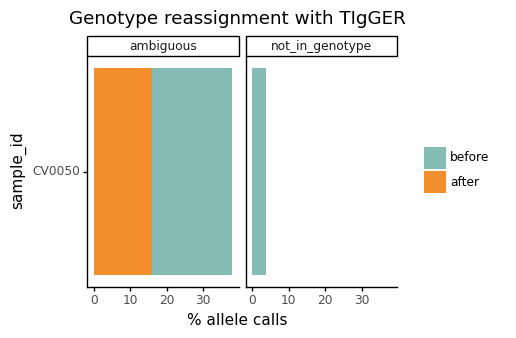

<ggplot: (1454179829073)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


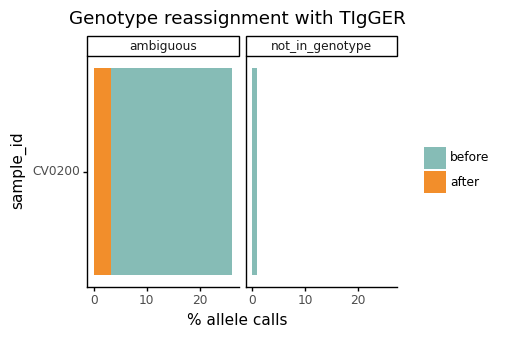

<ggplot: (1454178934101)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


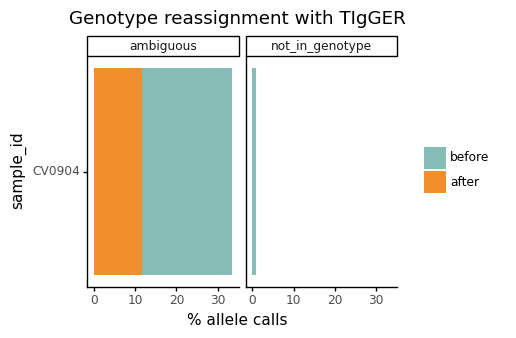

<ggplot: (1454179387377)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


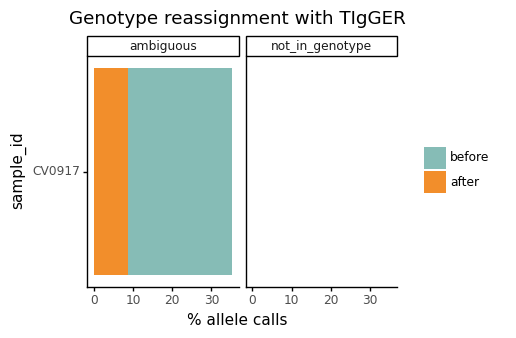

<ggplot: (1454177998241)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


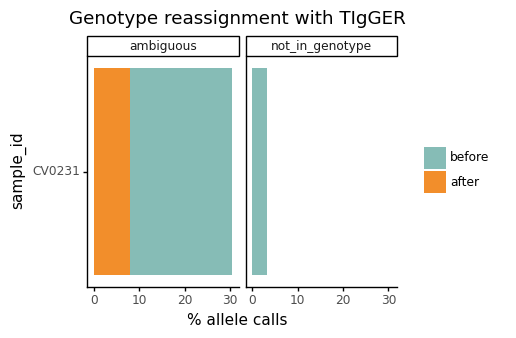

<ggplot: (1454177998877)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


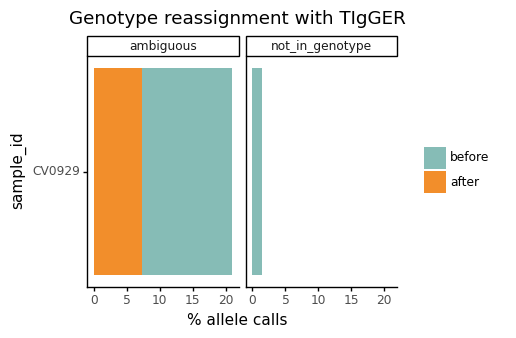

<ggplot: (1454188336085)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


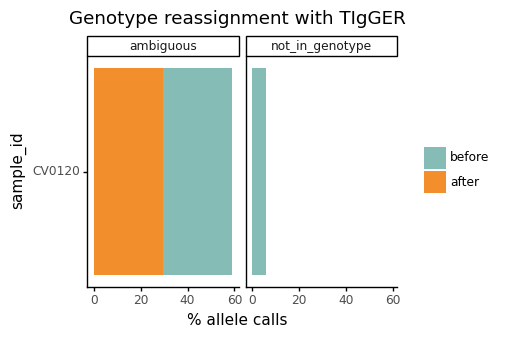

<ggplot: (1454188339705)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


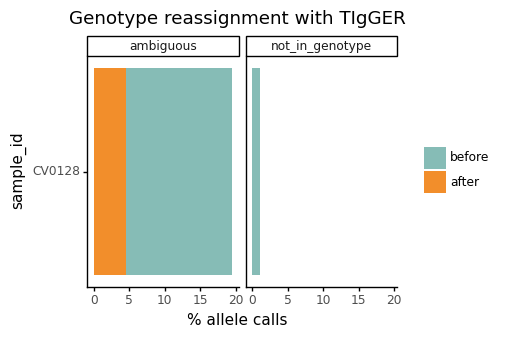

<ggplot: (1454177963273)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


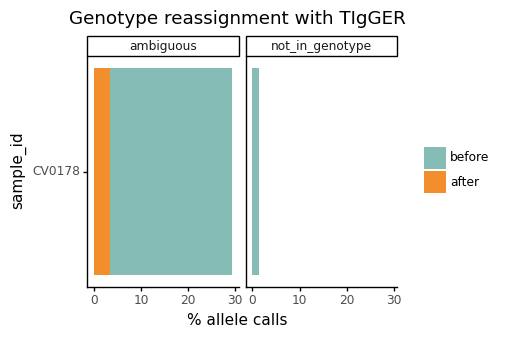

<ggplot: (1454181953225)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


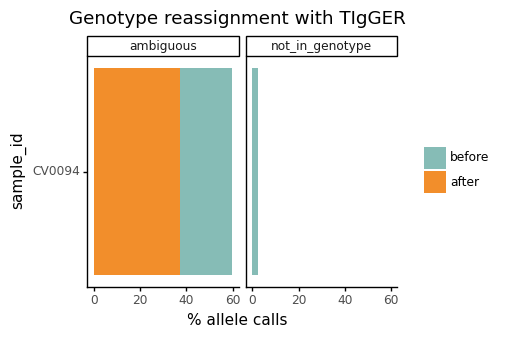

<ggplot: (1454187301665)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


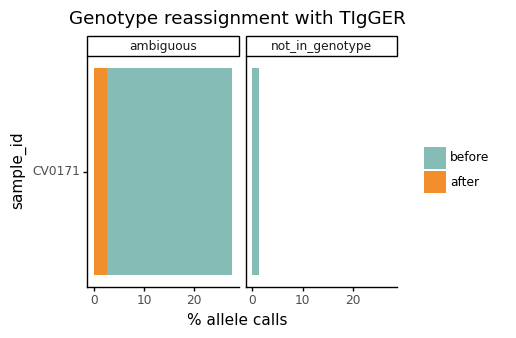

<ggplot: (1454180966069)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


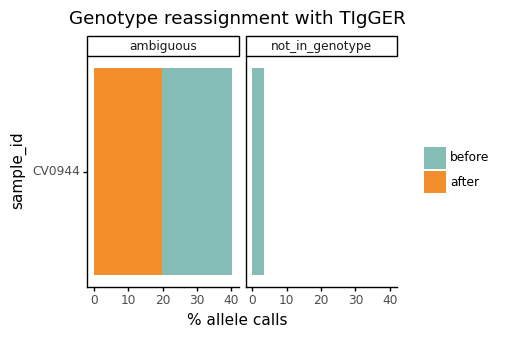

<ggplot: (1454187260017)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


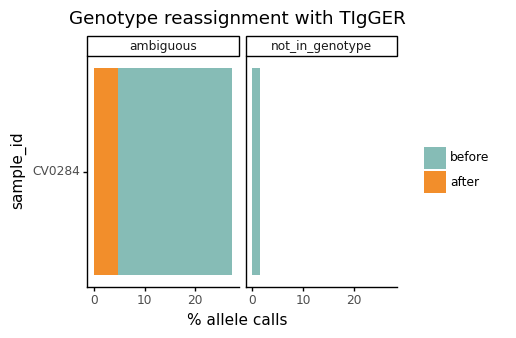

<ggplot: (1454179569773)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


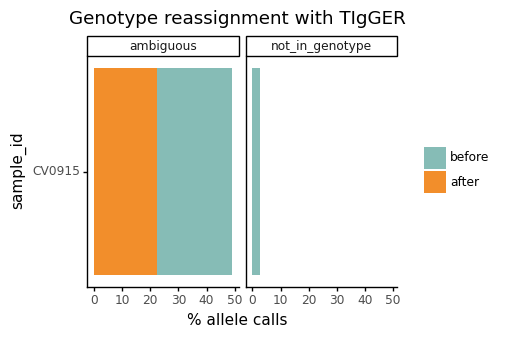

<ggplot: (1454180750425)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


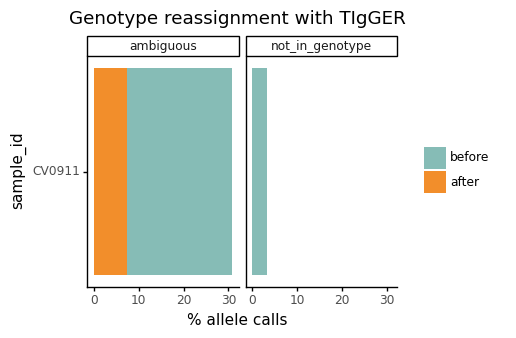

<ggplot: (1454180760353)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


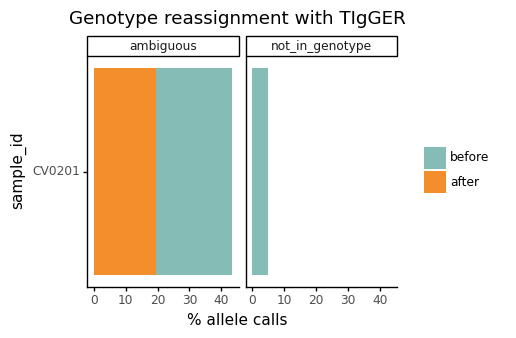

<ggplot: (1454178834205)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


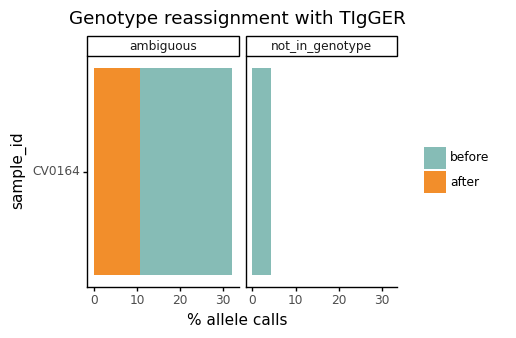

<ggplot: (1454177567829)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


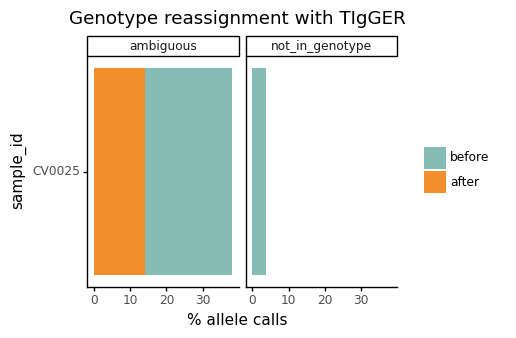

<ggplot: (1454177517977)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


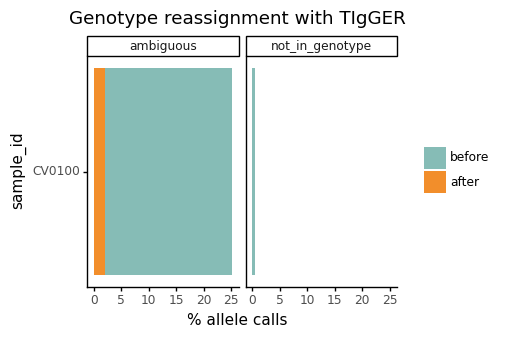

<ggplot: (1454177565641)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


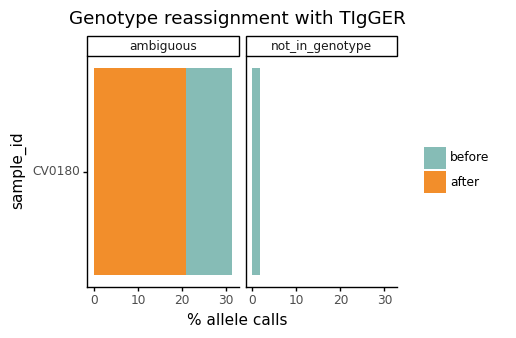

<ggplot: (1454180715389)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


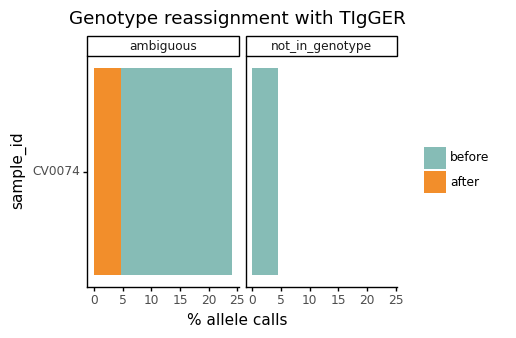

<ggplot: (1454186288089)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


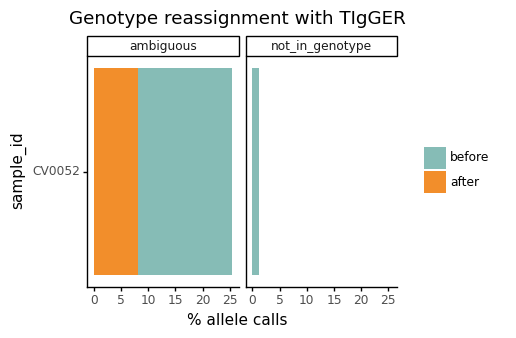

<ggplot: (1454186288001)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


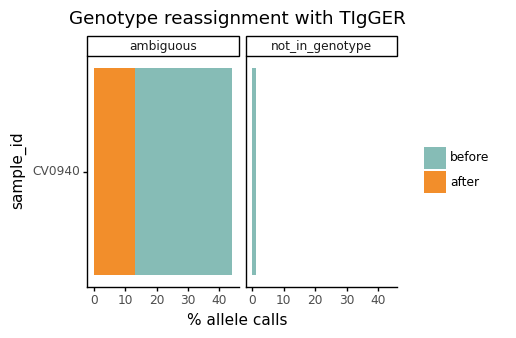

<ggplot: (1454179979033)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


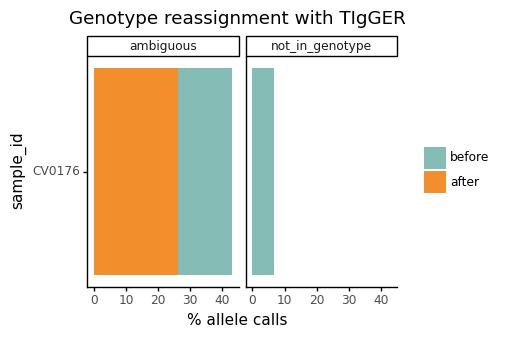

<ggplot: (1454178705205)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


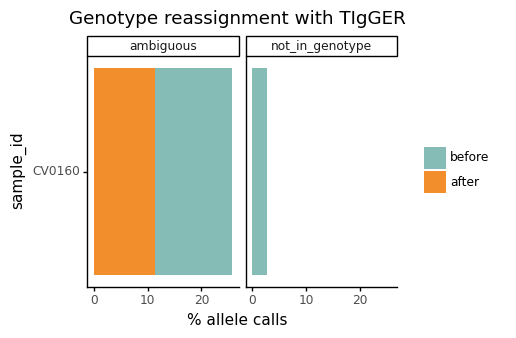

<ggplot: (1454177887365)>


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Insufficient contigs for running tigger-genotype. Defaulting to original heavy chain v_calls.
            Reconstructing heavy chain dmask germline sequences with v_call.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for heavy chain in `v_call` are copied to `v_call_genotyped`.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) :   0%|          | 0/1 [00:00<?, ?it/s]

Although tigger-genotype was not run successfully, file will still be saved with `_genotyped.tsv` extension for convenience.


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


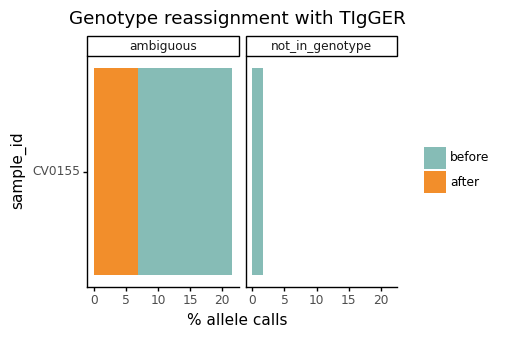

<ggplot: (1454177887321)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


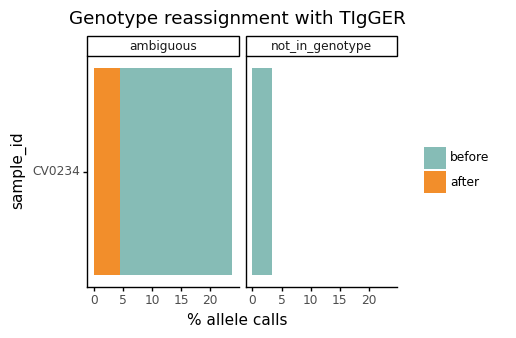

<ggplot: (1454181188645)>


Processing data file(s) : 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


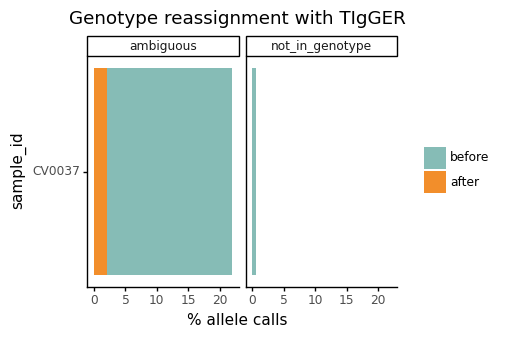

<ggplot: (1454181190393)>


Writing out to individual folders : 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


In [17]:
for folder_key, folder_value in group_dict.items():
    ddl.pp.reassign_alleles(folder_value, combined_folder = folder_key, sample_id_dictionary = group_dict)

Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 494/494 [00:02<00:00, 183.22it/s]


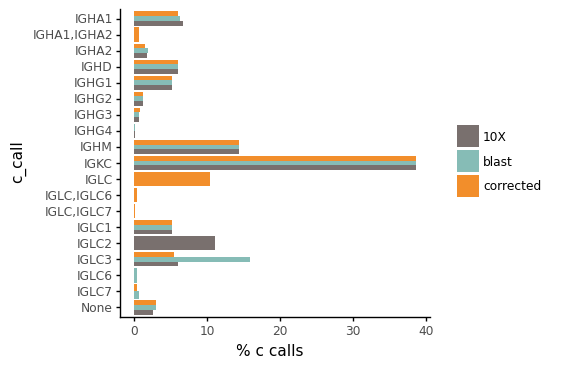

<ggplot: (1454178759677)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 751/751 [00:01<00:00, 414.24it/s]


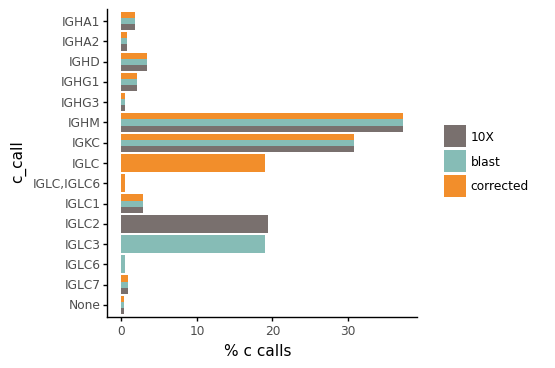

<ggplot: (1454179981449)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 783/783 [00:01<00:00, 612.98it/s]


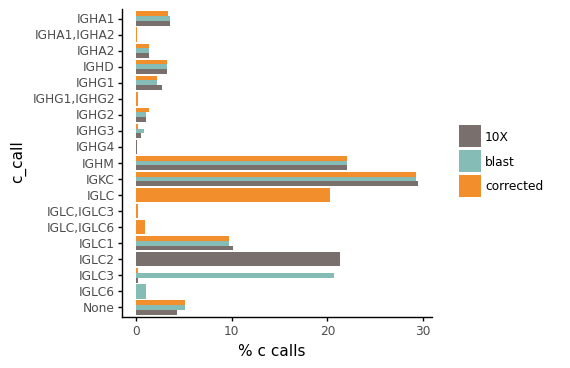

<ggplot: (1454177954425)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 580/580 [00:00<00:00, 647.84it/s]


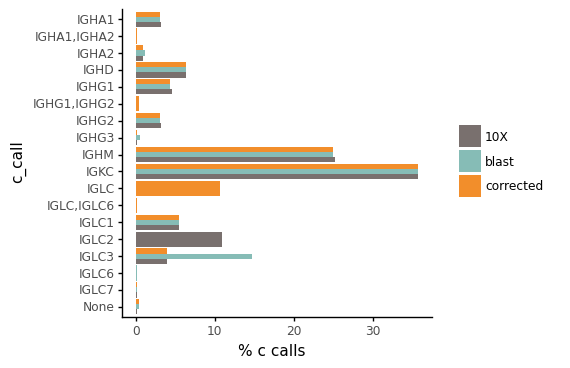

<ggplot: (1454338130249)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2219/2219 [00:06<00:00, 355.68it/s]


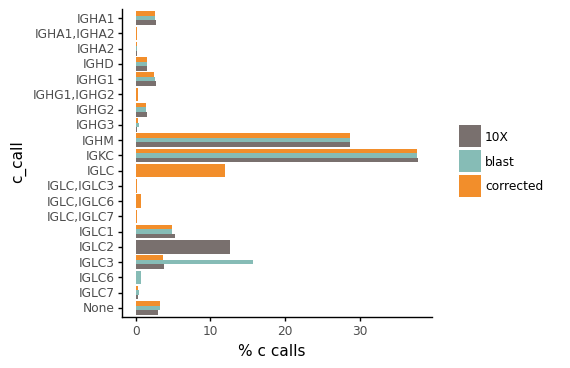

<ggplot: (1454180754753)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 213/213 [00:00<00:00, 583.16it/s]


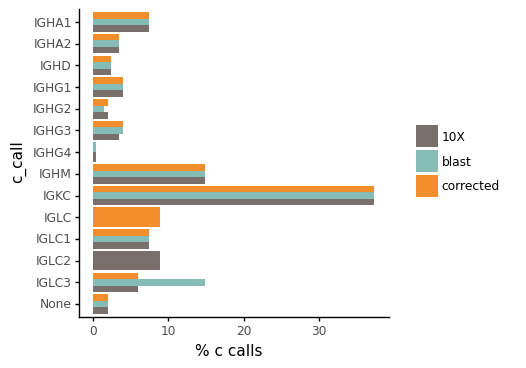

<ggplot: (1454338430173)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 667/667 [00:01<00:00, 526.08it/s]


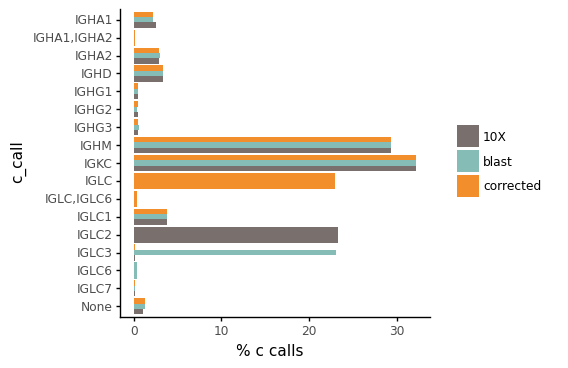

<ggplot: (1454338058437)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1860/1860 [00:05<00:00, 325.47it/s]


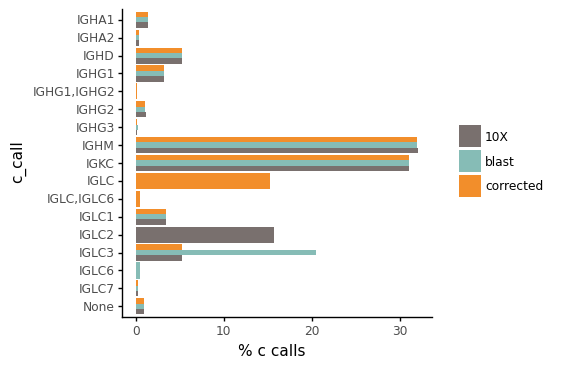

<ggplot: (1454177593277)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2630/2630 [00:10<00:00, 240.08it/s]


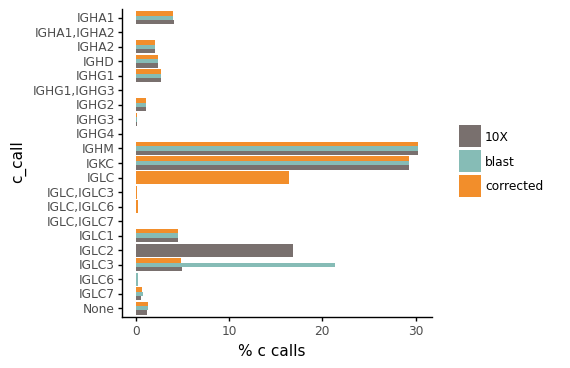

<ggplot: (1454180143137)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1357/1357 [00:02<00:00, 517.18it/s]


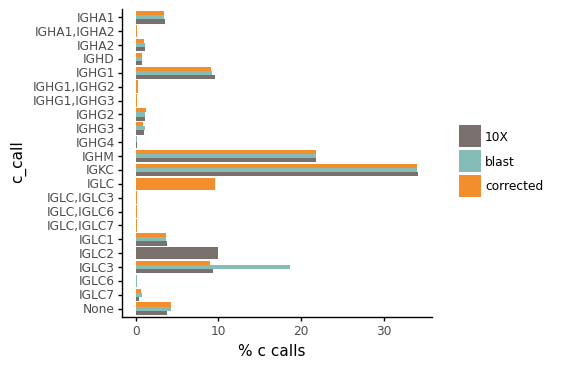

<ggplot: (1454338428185)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2016/2016 [00:05<00:00, 357.39it/s]


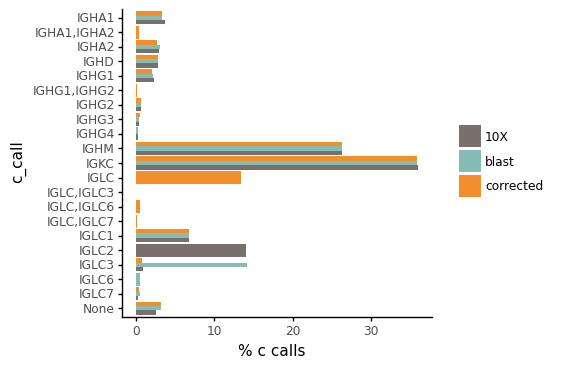

<ggplot: (1454177936577)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 516/516 [00:01<00:00, 499.58it/s]


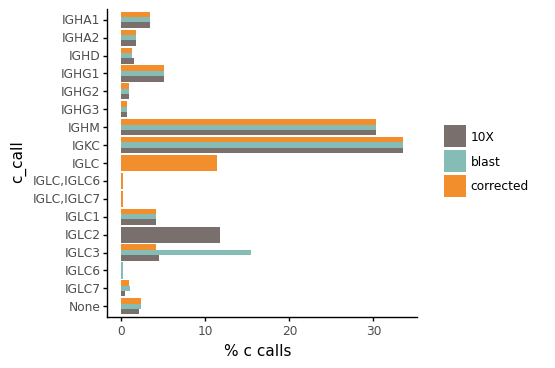

<ggplot: (1454187737693)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1403/1403 [00:02<00:00, 507.62it/s]


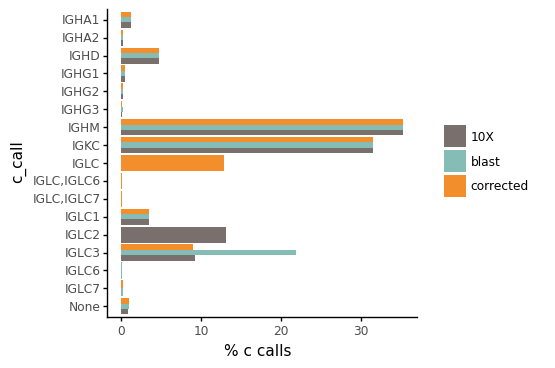

<ggplot: (1454177242125)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2582/2582 [00:09<00:00, 272.30it/s]


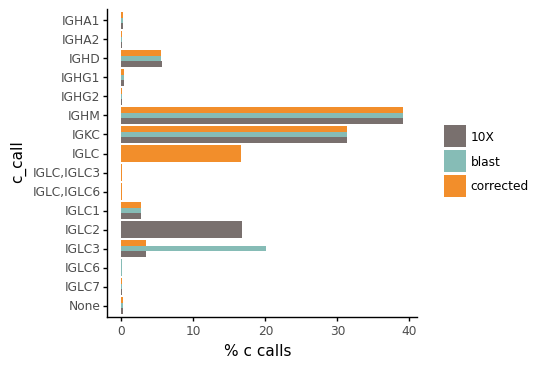

<ggplot: (1454178885097)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1388/1388 [00:02<00:00, 495.47it/s]


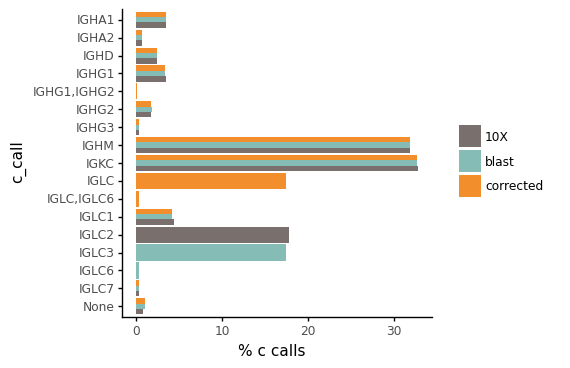

<ggplot: (1454180579649)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1364/1364 [00:02<00:00, 475.77it/s]


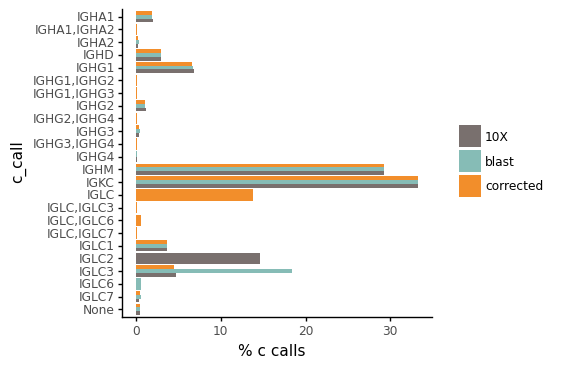

<ggplot: (1454180421813)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1656/1656 [00:04<00:00, 406.16it/s]


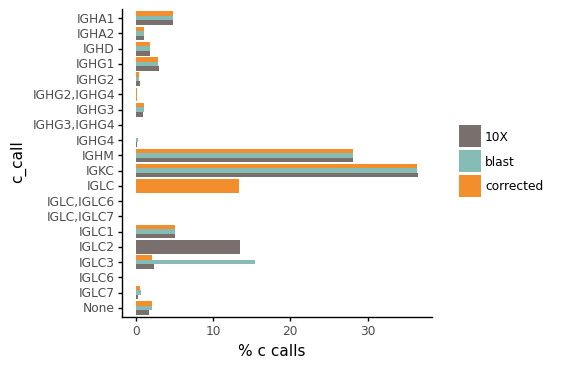

<ggplot: (1454179277085)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 4968/4968 [00:36<00:00, 137.85it/s]


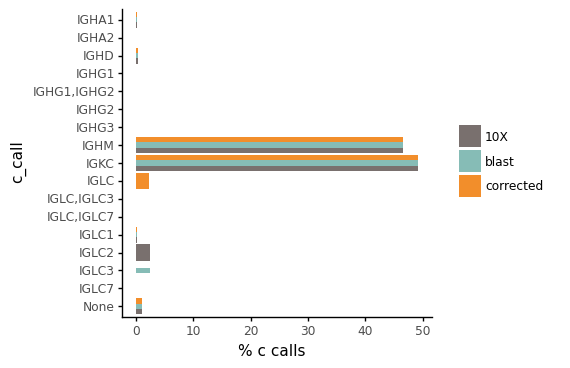

<ggplot: (1454179676289)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1142/1142 [00:02<00:00, 558.78it/s]


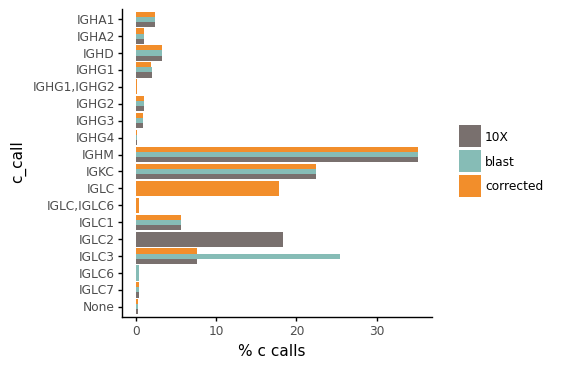

<ggplot: (1454177795957)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1592/1592 [00:03<00:00, 431.54it/s]


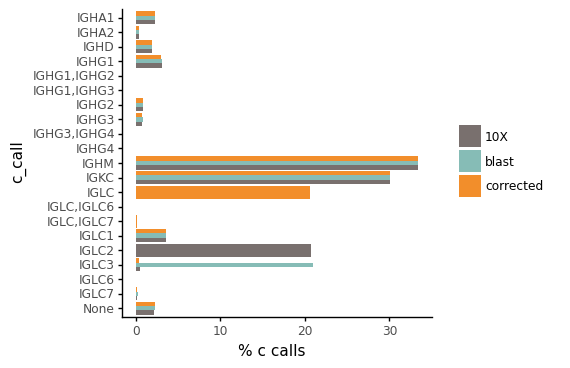

<ggplot: (1454179231493)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2020/2020 [00:06<00:00, 320.11it/s]


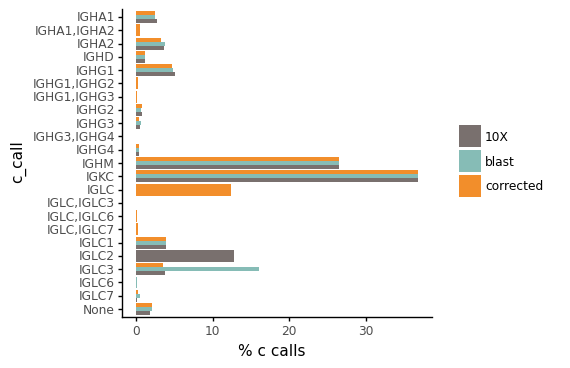

<ggplot: (1454179200721)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 642/642 [00:01<00:00, 613.00it/s]


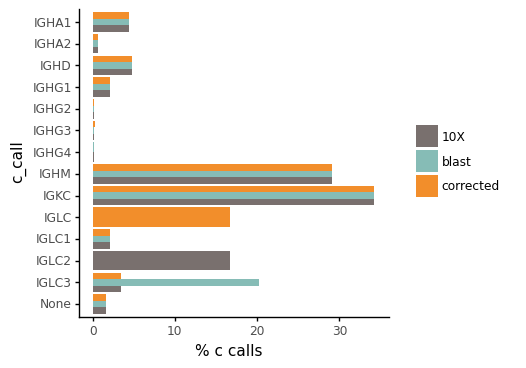

<ggplot: (1454338348705)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1299/1299 [00:01<00:00, 771.16it/s]


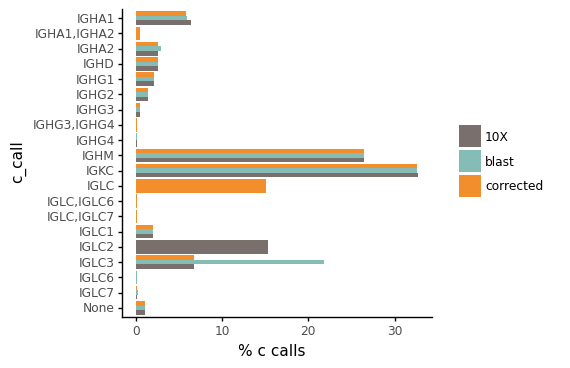

<ggplot: (1454178990585)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1270/1270 [00:02<00:00, 521.31it/s]


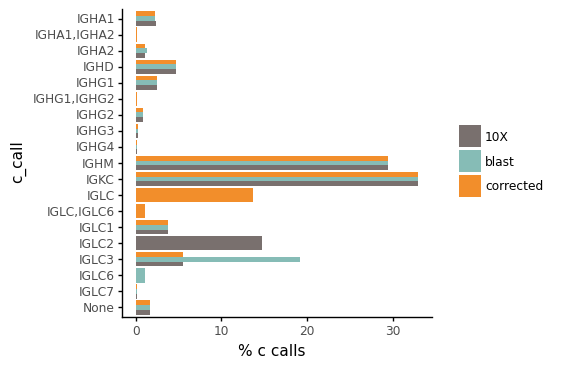

<ggplot: (1454179115177)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 443/443 [00:00<00:00, 750.48it/s]


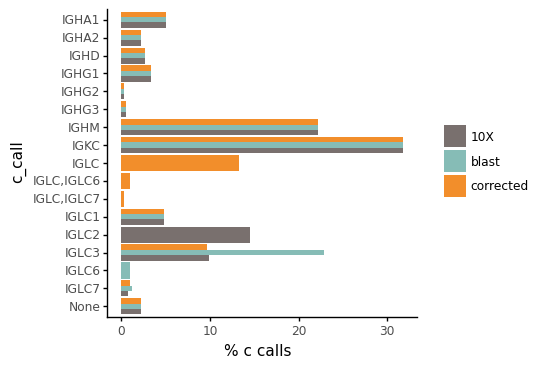

<ggplot: (1454338141497)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1786/1786 [00:04<00:00, 393.04it/s]


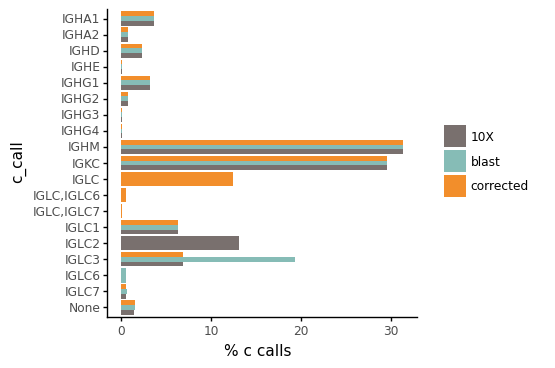

<ggplot: (1454179329505)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2927/2927 [00:12<00:00, 229.44it/s]


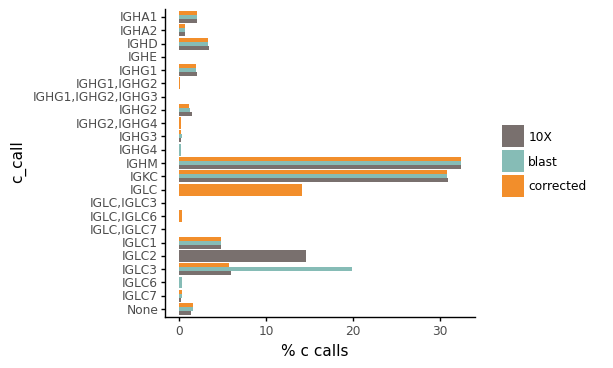

<ggplot: (1454178835737)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2508/2508 [00:08<00:00, 291.21it/s]


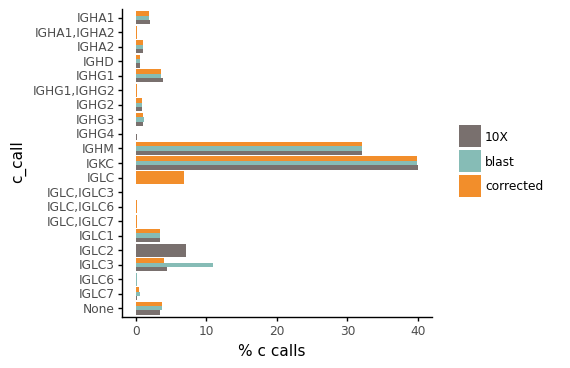

<ggplot: (1454179356593)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 4482/4482 [00:31<00:00, 140.66it/s]


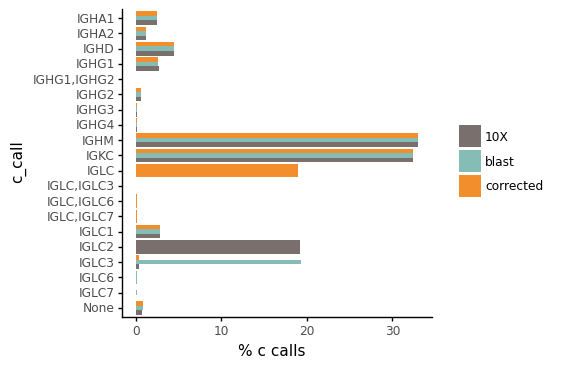

<ggplot: (1454187300105)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 391/391 [00:01<00:00, 319.56it/s]


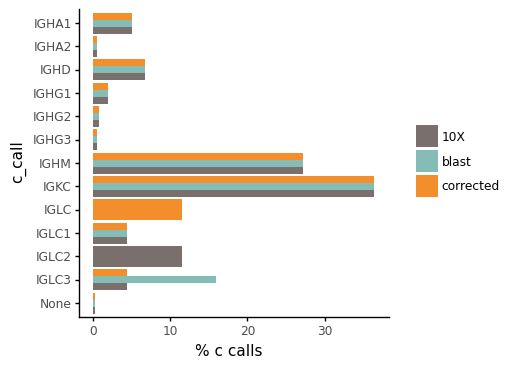

<ggplot: (1454188381009)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2368/2368 [00:07<00:00, 326.06it/s]


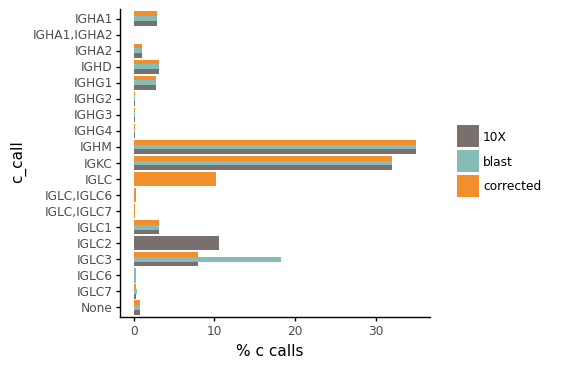

<ggplot: (1454177971925)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 564/564 [00:00<00:00, 592.66it/s]


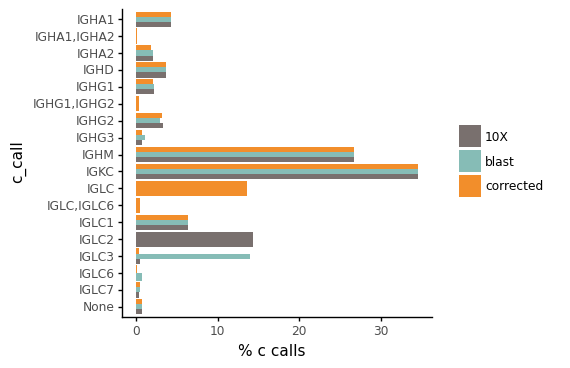

<ggplot: (1454178574009)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 537/537 [00:00<00:00, 553.95it/s]


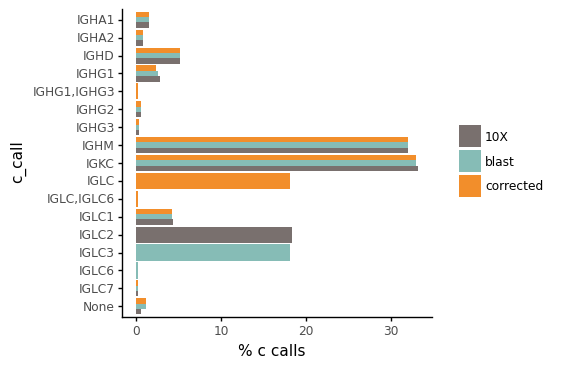

<ggplot: (1454187048837)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 588/588 [00:01<00:00, 558.06it/s]


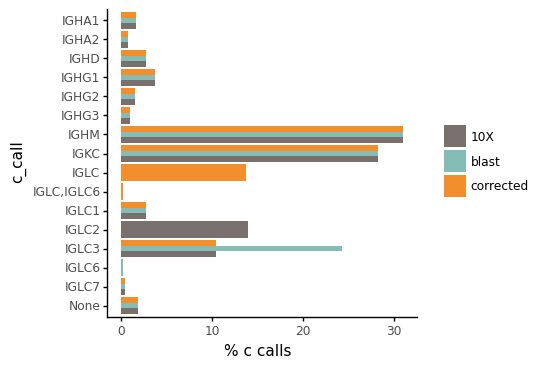

<ggplot: (1454338180325)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 898/898 [00:01<00:00, 553.53it/s]


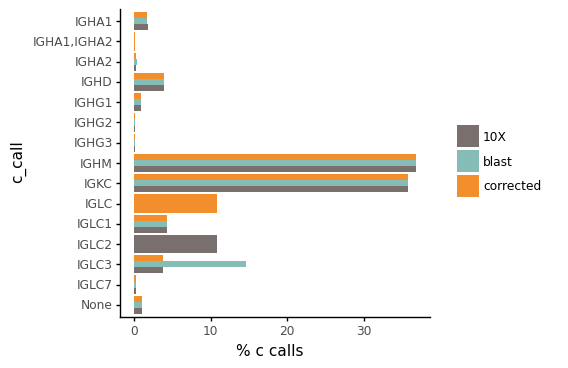

<ggplot: (1454338256225)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 988/988 [00:01<00:00, 876.63it/s]


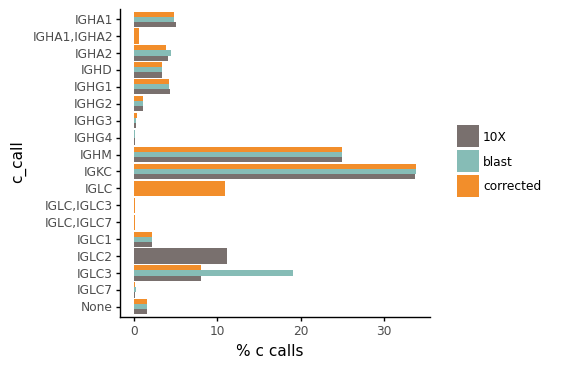

<ggplot: (1454187736477)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2749/2749 [00:10<00:00, 253.24it/s]


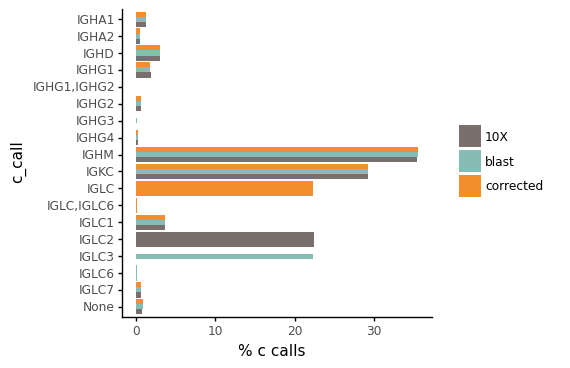

<ggplot: (1454177888557)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 453/453 [00:00<00:00, 490.65it/s]


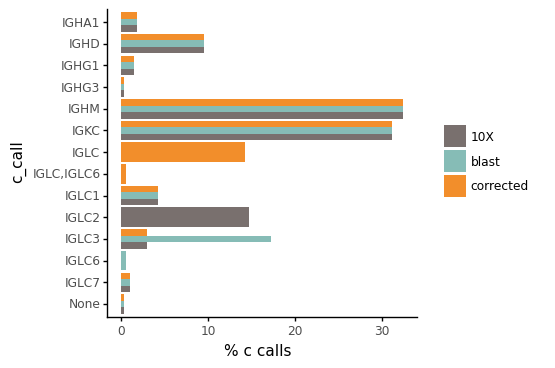

<ggplot: (1454338363661)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 4080/4080 [00:25<00:00, 158.30it/s]


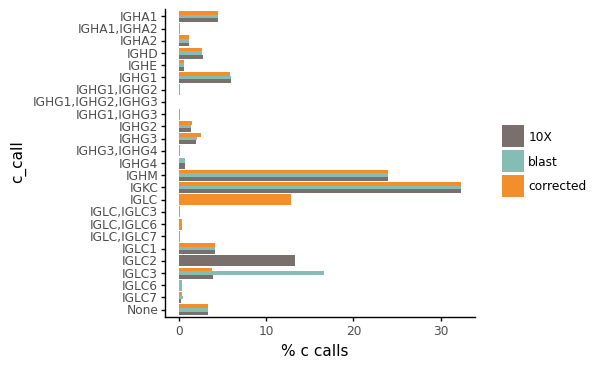

<ggplot: (1454180127701)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2235/2235 [00:07<00:00, 283.74it/s]


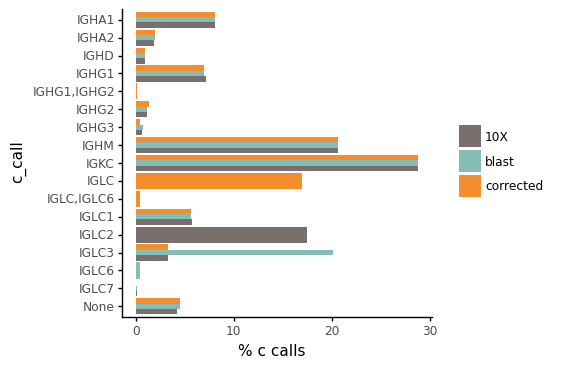

<ggplot: (1454177942461)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 623/623 [00:01<00:00, 541.19it/s]


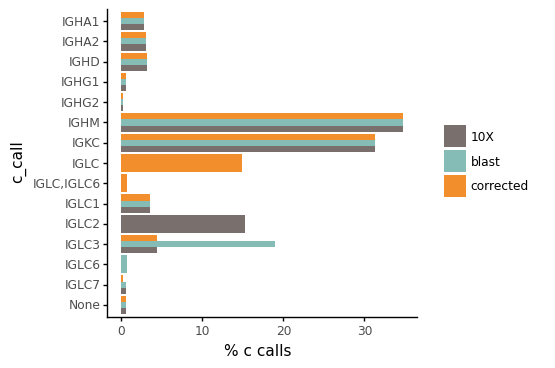

<ggplot: (1454178051545)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 549/549 [00:00<00:00, 561.07it/s]


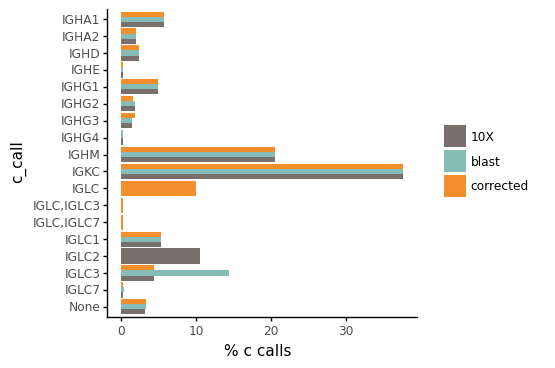

<ggplot: (1454187737949)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1271/1271 [00:02<00:00, 560.07it/s]


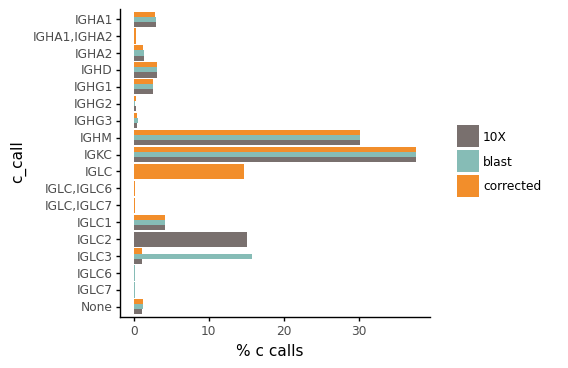

Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 14/14 [00:00<00:00, 6636.56it/s]

<ggplot: (1454178982961)>


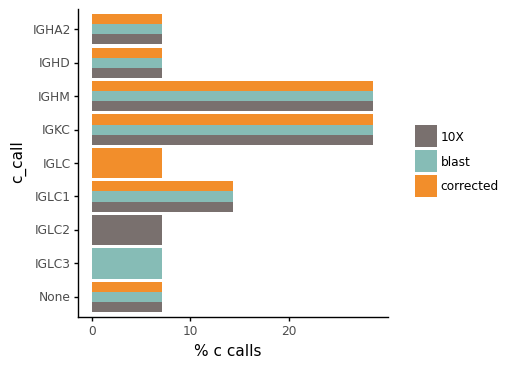

<ggplot: (1454338249545)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1152/1152 [00:02<00:00, 562.75it/s]


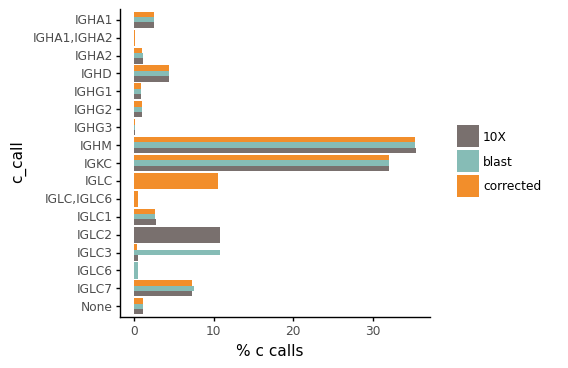

<ggplot: (1454179398853)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 2238/2238 [00:06<00:00, 342.24it/s]


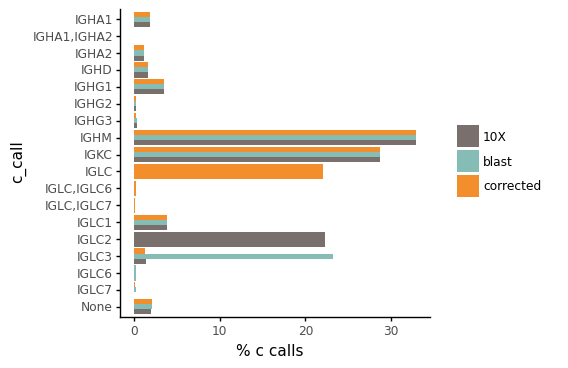

<ggplot: (1454179113757)>


Retrieving contant region calls, parallelizing with 31 cpus : 100%|██████████| 1743/1743 [00:04<00:00, 351.42it/s]


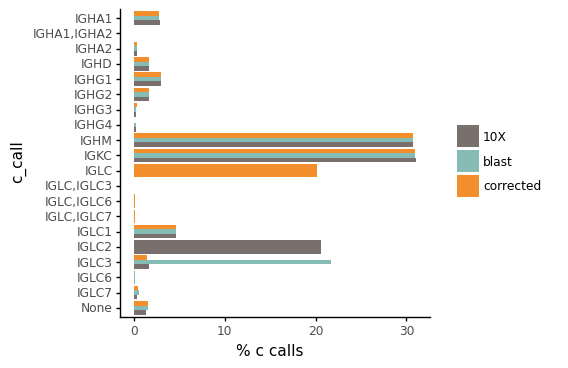

<ggplot: (1454179693045)>


In [18]:
ddl.pp.assign_isotypes(patients)

In [18]:
from tqdm import tqdm
# quantify mutations
for s in tqdm(patients, desc = 'Basic mutational load analysis '):
    filePath = s+'/dandelion/data/filtered_contig_igblast_db-pass_genotyped.tsv'
    ddl.pp.quantify_mutations(filePath)

Basic mutational load analysis : 100%|██████████| 47/47 [11:45<00:00, 15.02s/it]
